In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
import amort_bnn
import tqdm.auto as tqdm

torch.set_default_dtype(torch.float64)

/home/troch/venvs/amort-inf-bnn-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset here

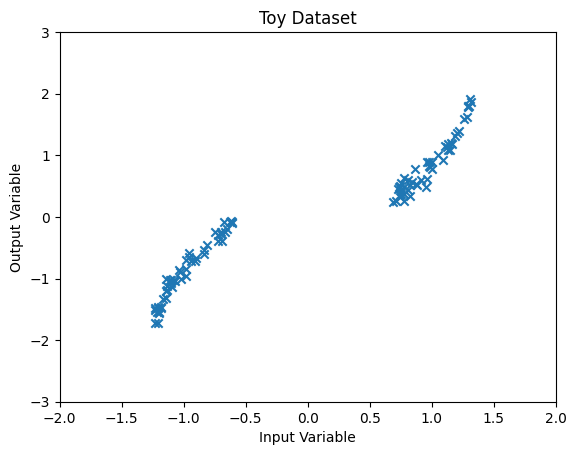

In [3]:
noise_std = torch.tensor(4.0)
dataset_size = 100

x_neg, x_pos = torch.zeros(dataset_size // 2), torch.zeros(dataset_size // 2)
x_neg, x_pos = x_neg.uniform_(-4, -2), x_pos.uniform_(2, 4)
x = torch.cat((x_neg, x_pos))

y = x**3 + noise_std * torch.normal(
    torch.zeros(dataset_size), torch.ones(dataset_size)
)

x = (x - x.mean()) / x.std()
y = (y - y.mean()) / y.std()

plt.scatter(x, y, marker="x")
plt.title("Toy Dataset")
plt.xlabel("Input Variable")
plt.ylabel("Output Variable")
plt.xlim(-2, 2)
plt.ylim(-3, 3)
plt.show()


In [4]:
amort_model = amort_bnn.AmortNetwork(
    1,
    [50, 50],
    1,
    x.unsqueeze(-1),
    y.unsqueeze(-1),
    infer_last_pseudos=False
)
print(amort_model)

opt = torch.optim.Adam(amort_model.parameters(), lr=1e-2)

AmortNetwork(
  (nonlinearity): ReLU()
  (network): ModuleList(
    (0): AmortLayer(
      (activation): ReLU()
      (inference_network): InferenceNetwork(
        (activation): ReLU()
        (network): ModuleList(
          (0): Linear(in_features=2, out_features=100, bias=True)
          (1): ReLU()
          (2): Linear(in_features=100, out_features=100, bias=True)
          (3): ReLU()
          (4): Linear(in_features=100, out_features=100, bias=True)
          (5): Identity()
        )
      )
    )
    (1): AmortLayer(
      (activation): ReLU()
      (inference_network): InferenceNetwork(
        (activation): ReLU()
        (network): ModuleList(
          (0): Linear(in_features=2, out_features=100, bias=True)
          (1): ReLU()
          (2): Linear(in_features=100, out_features=100, bias=True)
          (3): ReLU()
          (4): Linear(in_features=100, out_features=100, bias=True)
          (5): Identity()
        )
      )
    )
    (2): AmortLayer(
      (activation

In [5]:
loss_evo = []
ll_evo = []
kl_evo = []

epoch_iter = tqdm.tqdm(range(1000), "Epoch")
for epoch in epoch_iter:
    opt.zero_grad()

    loss, ll, kl, noise = amort_model.elbo_loss(
        x.unsqueeze(1), y.unsqueeze(1), num_samples=1
    )
    loss_evo.append(loss.item())
    ll_evo.append(ll.item())
    kl_evo.append(kl.item())

    loss.backward()
    opt.step()
    
    epoch_iter.set_postfix({"loss": loss, "ll": ll, "kl": kl})

Epoch: 100%|██████████| 1000/1000 [00:42<00:00, 23.54it/s, loss=tensor(-56.6235, grad_fn=<NegBackward0>), ll=tensor(91.9150, grad_fn=<MeanBackward0>), kl=tensor(35.2915, grad_fn=<MeanBackward0>)]


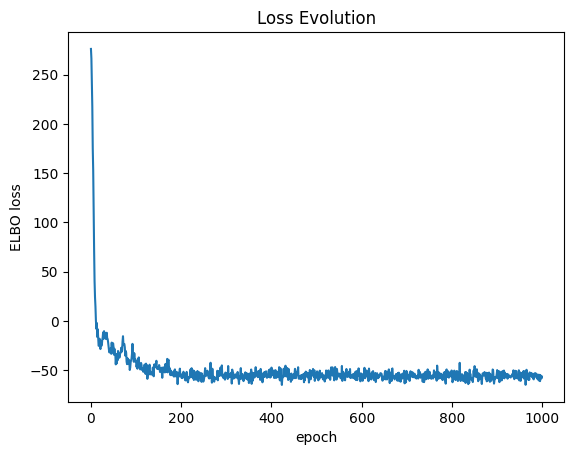

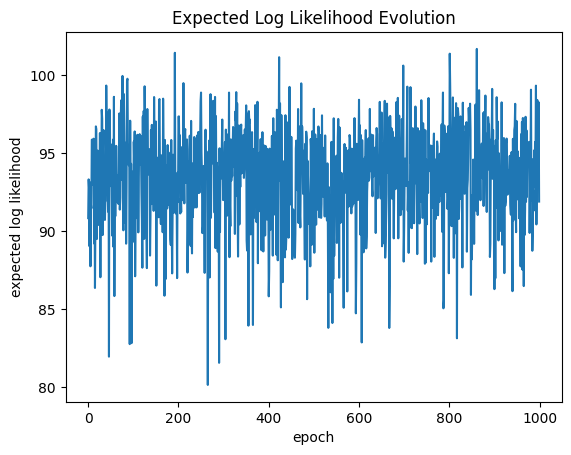

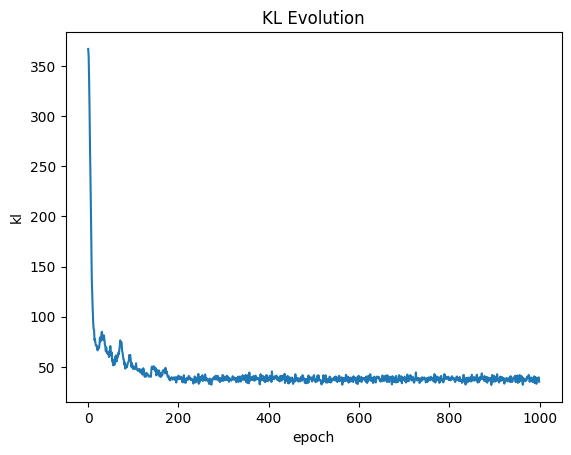

In [6]:
plt.plot(loss_evo)
plt.ylabel("ELBO loss")
plt.xlabel("epoch")
plt.title("Loss Evolution")
plt.show()

plt.plot(ll_evo)
plt.ylabel("expected log likelihood")
plt.xlabel("epoch")
plt.title("Expected Log Likelihood Evolution")
plt.show()

plt.plot(kl_evo)
plt.ylabel("kl")
plt.xlabel("epoch")
plt.title("KL Evolution")
plt.show()

In [7]:
xs = torch.linspace(-2.5, 2.5, 100).unsqueeze(1)
prediction_samps = amort_model(xs, num_samples=100)[0].squeeze(-1).T
predict_mean = prediction_samps.mean(1)
ip, op = amort_model.get_pseud_outs()

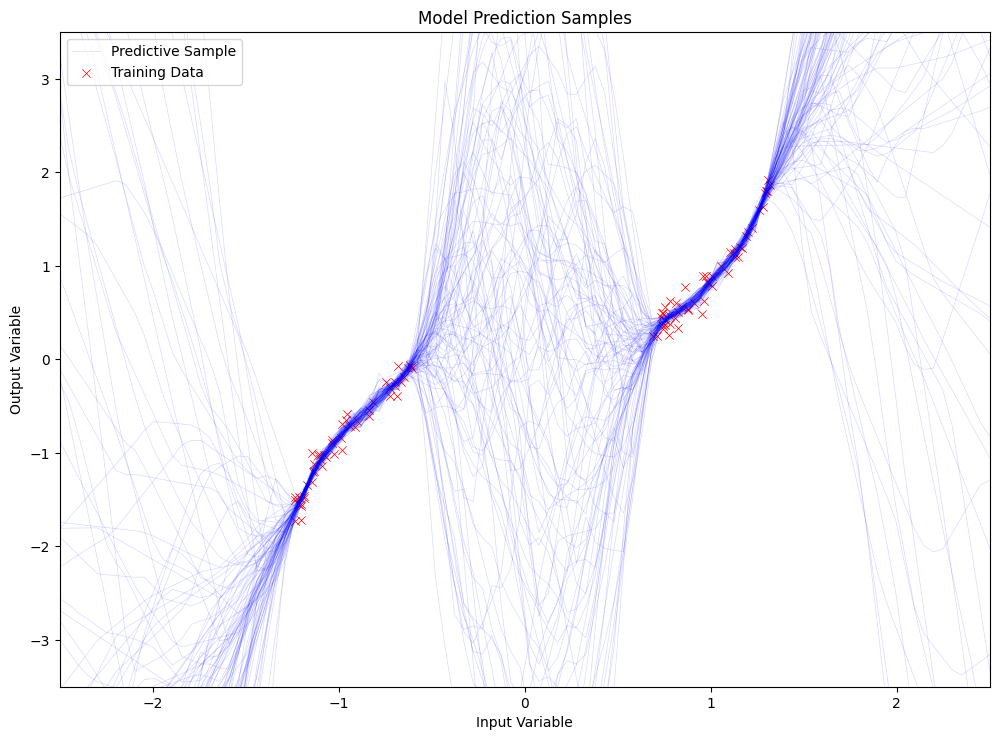

In [8]:
plt.figure(figsize=(12, 8.5))
plt.plot(
    xs,
    prediction_samps.detach().numpy()[:, :-1],
    color="blue",
    linewidth=0.5,
    alpha=0.15,
)
plt.plot(
    xs,
    prediction_samps.detach().numpy()[:, -1],
    color="blue",
    linewidth=0.5,
    alpha=0.15,
    label="Predictive Sample",
)
plt.title("Model Prediction Samples")
plt.xlabel("Input Variable")
plt.ylabel("Output Variable")
plt.scatter(x, y, marker="x", label="Training Data", color='red', linewidth=0.5)
# plt.plot(xs, predict_mean.detach().numpy(), color='blue')

infer_last = amort_model.network[-1].infer_last_pseudos
if infer_last:
    plt.scatter(ip, op, marker='+', label='Final Layer Inferred Pseudo Observations', color='black', linewidth=1.0)
    
plt.legend()
plt.xlim(-2.5, 2.5)
plt.ylim(-3.5, 3.5)
plt.show()